Getting started with JAX (MLPs, CNNs & RNNs) : https://roberttlange.com/posts/2020/03/blog-post-10/

We'll be using the notation of the blog post for ease

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

Let's use jit for a simple example

In [2]:
def ReLU(x): return jnp.maximum(0, x)

jit_ReLU = jit(ReLU)

There are differences between %time and %timeit:

%time just reports the "wall time" that it takes for the CPU to compute whatever function you call

%timeit 

for %time, especially for using jit compiled functions, the first time incurs a "compilation cost" which disables you from seeing the benefits of jit compiling your function at first. this is why in every tutorial that I see which uses %time, you end up needing to run it twice in order to showcase the actual speed up

This will not be the case for %timeit, because we are going to be calling the jit function 1,000 times and compare the time that it takes to do all of them, then get the average and std. from doing so. this is a more thoughtful benchmark to use

In [3]:
inp = 0.2

%time ReLU(inp).block_until_ready()
%time jit_ReLU(inp).block_until_ready()
%time jit_ReLU(inp).block_until_ready()
%time jit_ReLU(inp).block_until_ready()

CPU times: user 19 ms, sys: 1.97 ms, total: 20.9 ms
Wall time: 23 ms
CPU times: user 14.2 ms, sys: 1.17 ms, total: 15.3 ms
Wall time: 15 ms
CPU times: user 27 µs, sys: 26 µs, total: 53 µs
Wall time: 56.3 µs
CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 24.1 µs


Array(0.2, dtype=float32, weak_type=True)

In [4]:
%timeit ReLU(inp).block_until_ready()
%timeit jit_ReLU(inp).block_until_ready()
%timeit jit_ReLU(inp).block_until_ready()
%timeit jit_ReLU(inp).block_until_ready()

8.66 µs ± 88.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.69 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
5.73 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.2 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


So in this case we really only get a 2x speed up when using %timeit, which is fine, but it definitely doesn't look as strong as the first result. %timeit is definitely the way to go when i want to benchmark truly jit compiled things when i am building my networks

`jax.grad` is simple enough so i am going to skip it

`jax.vmap` allows you to map a function onto a vector

Example #1: Very simple, from 'cooking with JAX' file


In [5]:
# suppose we started with this simple dot product function
def f(x, y):
    return jnp.dot(x, y)

# for one dimensional inputs, this is all fine
x, y = jnp.array([1, 2]), jnp.array([3, 4])
f(x, y)

Array(11, dtype=int32)

In [6]:
# but say that x and y contain "batches"
x = jnp.array([[1, 2], [3, 4]])
y = jnp.array([[5, 6], [7, 8]])

# then if we want to compute f(x, y), we have to iterate over each batch
for xi, yi in zip(x, y): print(f(xi, yi))

17
53


In [7]:
# now imagine if dim(x) is huge, and the batch size is 64. this for loop is costly.
# instead, use vmap to vectorize the function mapping across each batch in x and y
import jax
fv = jax.vmap(f)
fv(x, y) # so quick and easy!

Array([17, 53], dtype=int32)

In essence, we can utilize a single function definition to be able to apply it across
D dimensional vectors that have batches in them of whatever constant dimension.

Now let's go back to the blog post

In [8]:
# Suppose we are going to process a 100 dimensional feature vector, and process it
# through a 512 hidden layer and a ReLU (seems backwards, at least from prev experience)
# I thought we had a 512 hidden layer, ReLU and then squash it to the feature vector

In [9]:
from jax import random
import jax.numpy as jnp

batch_dim, feature_dim, hidden_dim = 32, 100, 512

# Generate a batch of vectors to be processed (?)
X = random.normal(key, (batch_dim, feature_dim)) # (32, 100)

# Generate our parameters, which will be Gaussian weights and biases
params = [
            random.normal(key, (hidden_dim, feature_dim)), # weights
            random.normal(key, (hidden_dim,)) # biases
        ] 

# define the ReLU layer, 
def relu_layer(params, x): 
    ''' 
        Simple ReLU layer 
    
    args: params: dim(params[0]) = (h, f)
                  dim(params[1]) = (h,)
                  
          X: dim(x) = (f,), which is how many feature dims there are per batch
        
        '''
    return ReLU(jnp.dot(params[0], x) + params[1]) # (h, f) * (b, f) = (512, )

# now define the vectorized version
def vmap_relu_layer(params, x):
    ''' 
        Apply vmap to ReLU layer 
        
    args: vmap: handing relu_layer to the function itself
          in_axes specifies the arguments that are being given
              in_axes[0] = params, in_axes[1] = x
            
            in_axes=(None, 0) tells vmap to not map over in_axes[0], i.e. don't
            iterate over param , so this way the params gets broadcasted across the batch, which is what we want
            
            then, we are going to specify that we want to map over X, 
            but in its 0th dimension,
            so in this case, we're going to map over X[0], which dim(X[0]) = f
            
            this means for each batch dim, we're going to apply the maping over
            the entire feature vector, so we're unstacking X with respect to each batch, 
            and then we're going to be applying params[0] * X[0] along that, which gives
            (h, f) * (f,); this will give us a dim h vector.
            then, we'll do this b times for how many layers we'll have
            
            out_axes = 0 specifies the output axes, and from the argument that we're
            mapping over, we want the 0th dimension of it, which is b
    '''
    return vmap(relu_layer, in_axes=(None, 0), out_axes=0)

In [10]:
params[0].shape, X.shape, X[0, :].shape, jnp.dot(params[0], X[0, :]).shape, len([relu_layer(params, X[i, :]) for i in range(X.shape[0])])

((512, 100), (32, 100), (100,), (512,), 32)

In [11]:
# to run this WITHOUT using vmap, you have to iterate over each batch
# in a for loop
out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])

# with vmap, you don't have to do this, because the function will be mapped
# onto the feature vector dimension of each batch
out = vmap_relu_layer(params, X)
out

<function __main__.relu_layer(params, x)>

How are we ever going to be able to see what's inside out in this case?

Next: Train the MNIST MLP in JAX

In [21]:
import torch, time
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [13]:
# using his code for importing MNIST data'
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [36]:
images, labels = next(iter(train_loader))
images[0, 0].shape

torch.Size([28, 28])

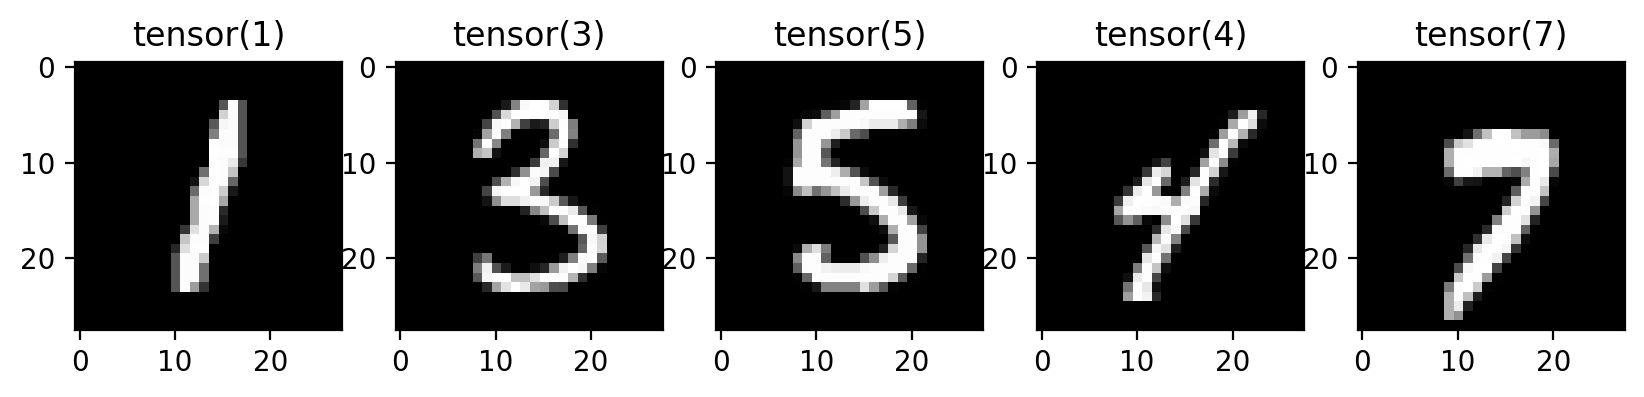

In [43]:
ncols = 5
fig, axs = plt.subplots(1, ncols, figsize=(10, 2))
for i in range(ncols):
    axs[i].imshow(images[i, 0, :, :], cmap='gray')
    axs[i].set_title(labels[i])

We're going to build the MLP layer from scratch. 

In [44]:
from jax import random

In [78]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    # To generate the network's weights, need to do proper PRNG key management
    keys = random.split(key, len(sizes))
    
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        # initialize weights and biases for the single layer
        w_key, b_key = random.split(key)
        w = scale * random.normal(w_key, (n, m))
        b = scale * random.normal(b_key, (n,))
        return w, b
    
    MLP = [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    return MLP

# initialize the sizes of the layers
layer_sizes = [28*28, 512, 512, 10]

# the MLP itself
params = initialize_mlp(layer_sizes, key)

Now let's compute the forward pass

In [82]:
def forward_pass(params, in_array):
    ''' 
        Compute forward pass for one single batch
        -- we'll use vmap to map across all batches
    '''
    # activations are the inputs (?)
    activations = in_array
    print(activations.shape)
    
    # loop over all of the ReLU layers
    for w, b in params[-1]:
        activations = relu_layer([w, b], activations)
        
    # activate the final layer based on final weights and biases
    final_w, final_b = params[-1]
    
    # form logits through the linear activation
    logits = np.dot(final_w, activations) + final_b
    
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

I'm stopping here because I feel like I'm just going through the motions here. It feels outdated and not the way to think about training a 2-layer MLP in the modern JAX way. I want to use Flax to do this anyway. Let's move on. 